In [1]:
import cv2
import numpy as np
import sys
sys.path.append('..')
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 16,16


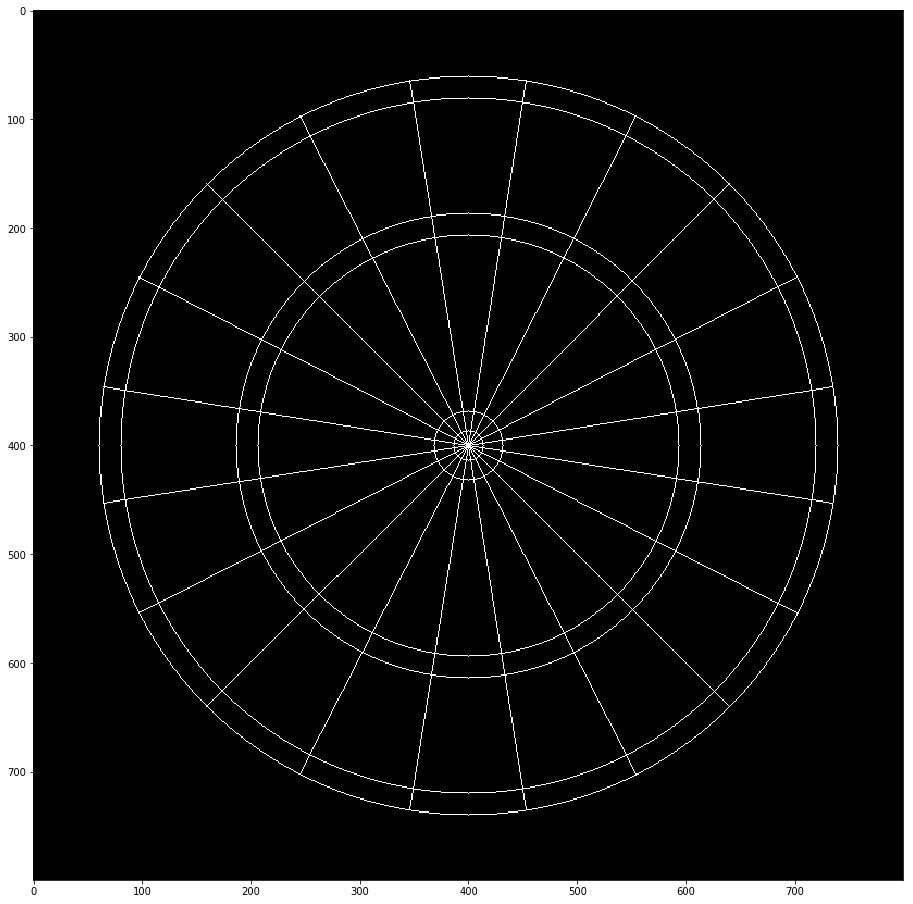

In [2]:
## improve and make circle radius accessible
def drawBoard():
    raw_loc_mat = np.zeros((800, 800, 3))
    radii = [170, 160, 107, 97, 16, 7]
    # Draw Circles
    [cv2.circle(raw_loc_mat, (400, 400), r * 2, (255, 255, 255), 1) for r in radii]
    # Draw Lines
    sectorangle = 2 * np.pi / 20
    for i in range(20):
        cv2.line(raw_loc_mat, (400, 400), (
            int(400 + 170 * 2 * np.cos((0.5 + i) * sectorangle)),
            int(400 + 170 * 2 * np.sin((0.5 + i) * sectorangle))), (255, 255, 255), 1)

    return raw_loc_mat

dart_mask = drawBoard()
dart_mask[np.where(dart_mask>0)]=1
plt.imshow(dart_mask)

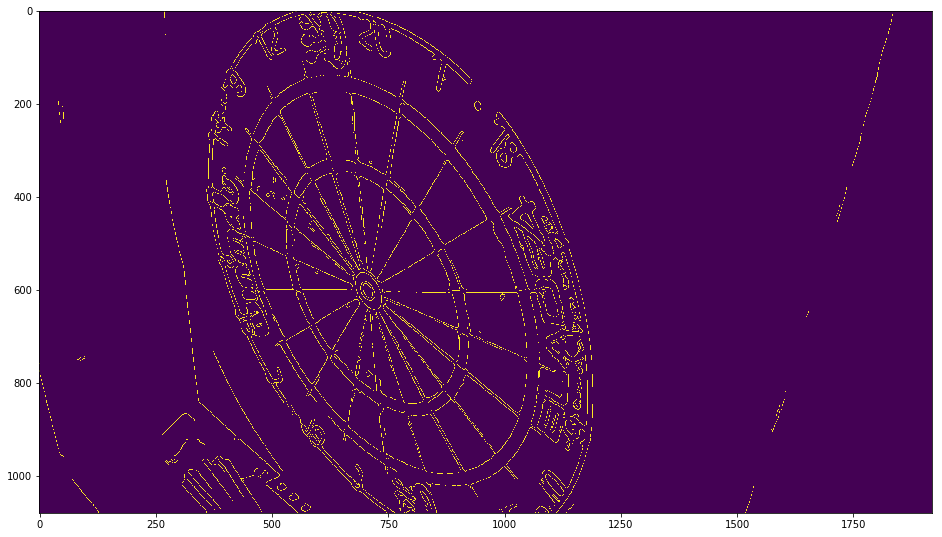

In [60]:
cap = cv2.VideoCapture('../Darts/Darts_Testvideo_9.mp4')
ret, frame = cap.read()
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
blurred = cv2.medianBlur(gray, 7,7)
edges = cv2.Canny(blurred, 150,250)
plt.imshow(edges)

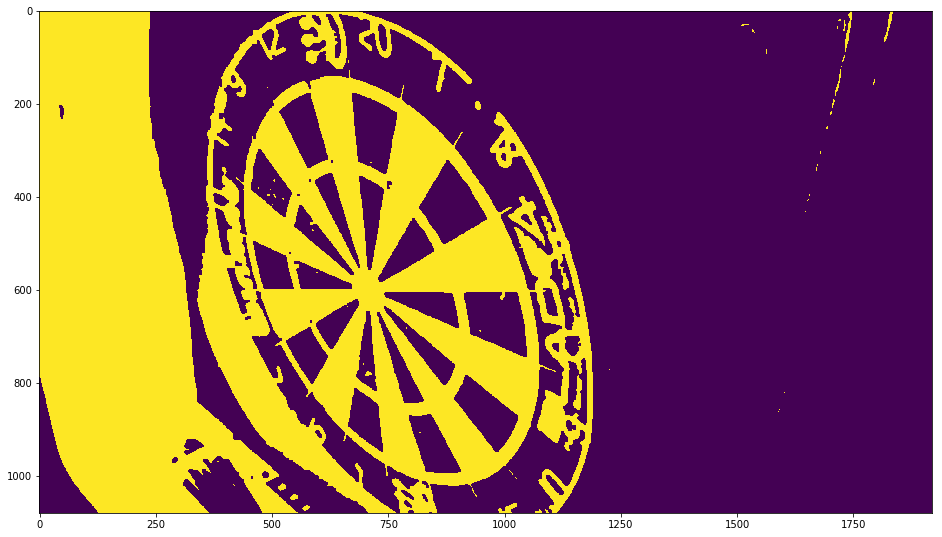

In [61]:
from Classes import EllipseDef
def findEllipse(thresh2, image_proc_img):

    Ellipse = EllipseDef()

    _, contours, hierarchy = cv2.findContours(thresh2, 1, 2)

    minThresE = 50000/4
    maxThresE = 1000000/4

    ## contourArea threshold important -> make accessible
    for cnt in contours:
        try:  # threshold critical, change on demand?
            if minThresE < cv2.contourArea(cnt) < maxThresE:
                ellipse = cv2.fitEllipse(cnt)
                cv2.ellipse(image_proc_img, ellipse, (0, 255, 0), 2)

                x, y = ellipse[0]
                a, b = ellipse[1]
                angle = ellipse[2]

                center_ellipse = (x, y)
                a = a / 2
                b = b / 2

                cv2.ellipse(image_proc_img, (int(x), int(y)), (int(a), int(b)), int(angle), 0.0, 360.0,
                            (255, 0, 0))
        # corrupted file
        except:
            print "error"
            return Ellipse, image_proc_img

    Ellipse.a = a
    Ellipse.b = b
    Ellipse.x = x
    Ellipse.y = y
    Ellipse.angle = angle
    return Ellipse, image_proc_img

def getTransformationPoints(img):
    imCalHSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    kernel = np.ones((5, 5), np.float32) / 25
    blur = cv2.filter2D(imCalHSV, -1, kernel)
    h, s, imCal = cv2.split(blur)

    ## threshold important -> make accessible
    #ret, thresh = cv2.threshold(imCal, 140, 255, cv2.THRESH_BINARY_INV)
    ret, thresh = cv2.threshold(imCal, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    ## kernel size important -> make accessible
    # very important -> removes lines outside the outer ellipse -> find ellipse
    kernel = np.ones((5, 5), np.uint8)
    thresh2 = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    # find enclosing ellipse
    return thresh2

thresh2 = getTransformationPoints(frame)
plt.imshow(thresh2)
elipse, img = findEllipse(thresh2, frame)


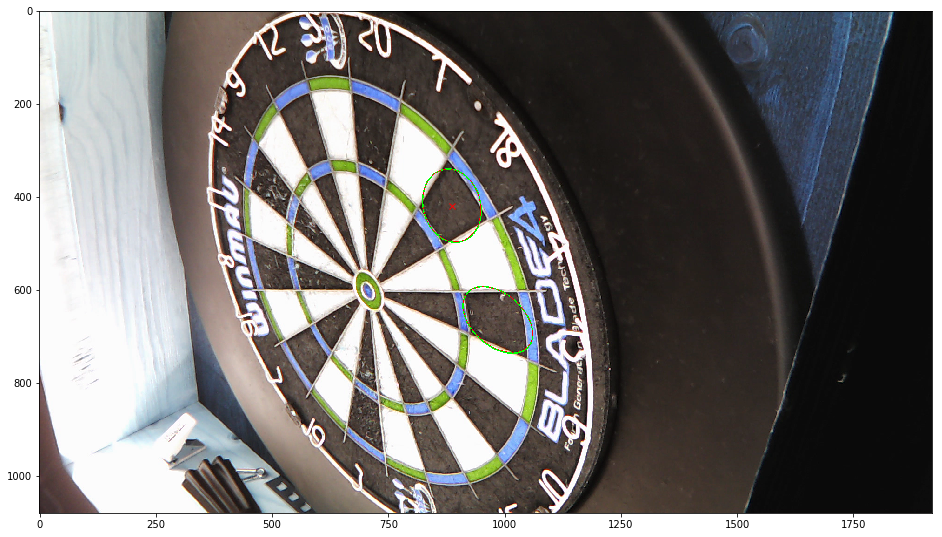

In [62]:
plt.imshow(frame)
plt.plot(x,y, 'rx')

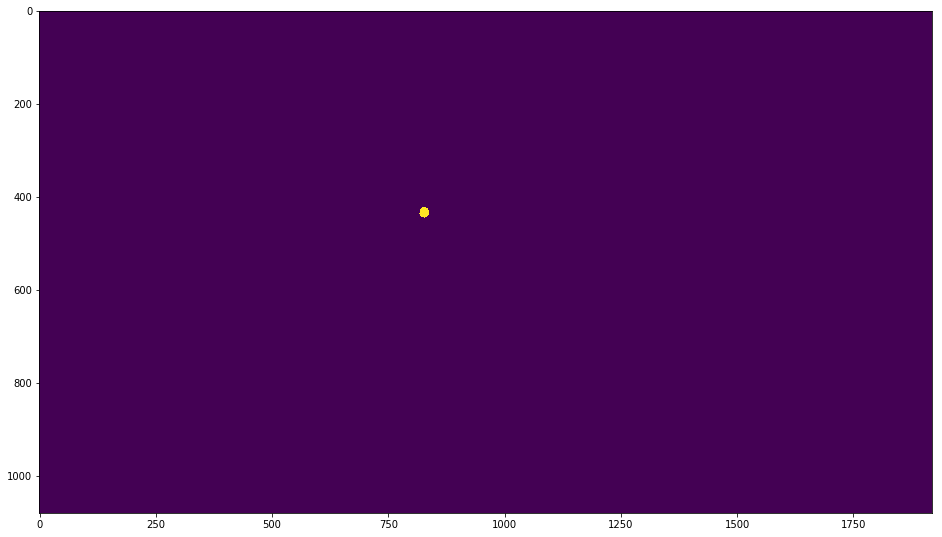

In [63]:
img = np.zeros_like(edges)
x,y,a,b,alpha = int(elipse.x), int(elipse.y), int(elipse.a), int(elipse.b), int(elipse.angle)
cv2.ellipse(img, (x,y), (a,b), alpha, 1, 0, 360, 20)
plt.imshow(img)

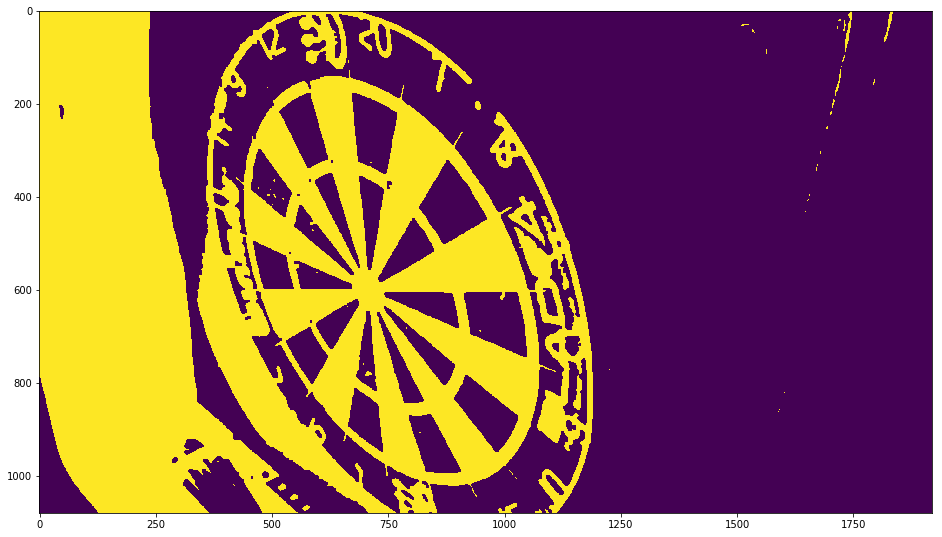

In [22]:
    # return the edged image
    edged = autocanny(thresh2)  # imCal
    cv2.imshow("test", edged)

    # find 2 sector lines -> horizontal and vertical sector line -> make angles accessible? with slider?
    if mount == "right":
        angleZone1 = (Ellipse.angle - 5, Ellipse.angle + 5)
        angleZone2 = (Ellipse.angle - 100, Ellipse.angle - 80)
        lines_seg, image_proc_img = findSectorLines(edged, image_proc_img, angleZone1, angleZone2)
    else:
        lines_seg, image_proc_img = findSectorLines(edged, image_proc_img, angleZone1=(80, 120), angleZone2=(30, 40))

    cv2.imshow("test4", image_proc_img)

    # ellipse 2 circle transformation to find intersection points -> source points for transformation
    M = ellipse2circle(Ellipse)
    intersectp_s = getEllipseLineIntersection(Ellipse, M, lines_seg)

    source_points = []

    try:
        new_intersect = np.mean(([intersectp_s[0],intersectp_s[4]]), axis=0, dtype=np.float32)
        source_points.append(new_intersect) # top
        new_intersect = np.mean(([intersectp_s[1], intersectp_s[5]]), axis=0, dtype=np.float32)
        source_points.append(new_intersect) # bottom
        new_intersect = np.mean(([intersectp_s[2], intersectp_s[6]]), axis=0, dtype=np.float32)
        source_points.append(new_intersect) # left
        new_intersect = np.mean(([intersectp_s[3], intersectp_s[7]]), axis=0, dtype=np.float32)
        source_points.append(new_intersect) # right
    except:
        pointarray = np.array(intersectp_s)
        top_idx = [np.argmin(pointarray[:, 1])][0]
        bot_idx = [np.argmax(pointarray[:, 1])][0]
        if mount == "right":
            left_idx = [np.argmin(pointarray[:, 0])][0]
            right_idx = [np.argmax(pointarray[:, 0])][0]
        else:
            left_idx = [np.argmax(pointarray[:, 0])][0]
            right_idx = [np.argmin(pointarray[:, 0])][0]
        source_points.append(intersectp_s[top_idx])  # top
        source_points.append(intersectp_s[bot_idx])  # bottom
        source_points.append(intersectp_s[left_idx])  # left
        source_points.append(intersectp_s[right_idx])  # right

    cv2.circle(image_proc_img, (int(source_points[0][0]), int(source_points[0][1])), 3, (255, 0, 0), 2, 8)
    cv2.circle(image_proc_img, (int(source_points[1][0]), int(source_points[1][1])), 3, (255, 0, 0), 2, 8)
    cv2.circle(image_proc_img, (int(source_points[2][0]), int(source_points[2][1])), 3, (255, 0, 0), 2, 8)
    cv2.circle(image_proc_img, (int(source_points[3][0]), int(source_points[3][1])), 3, (255, 0, 0), 2, 8)

    winName2 = "th circles?"
    cv2.namedWindow(winName2, cv2.CV_WINDOW_AUTOSIZE)
    cv2.imshow(winName2, image_proc_img)

    end = cv2.waitKey(0)
    if end == 13:
        cv2.destroyAllWindows()
        return source_points
plt.imshow(getTransformationPoints(frame))

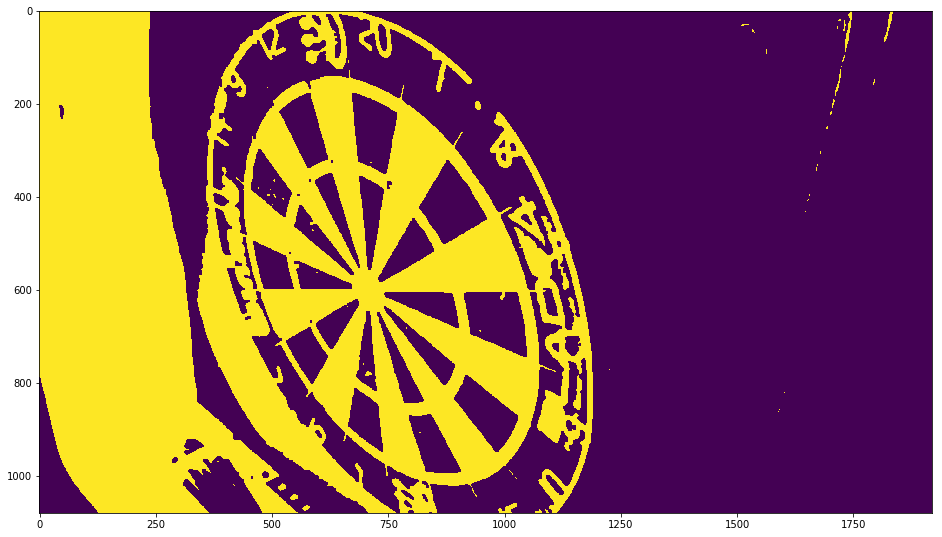

In [ ]:
from Classes import EllipseDef
def findEllipse(thresh2, image_proc_img):

    Ellipse = EllipseDef()

    _, contours, hierarchy = cv2.findContours(thresh2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    minThresE = 200000/4
    maxThresE = 1000000/4

    ## contourArea threshold important -> make accessible
    for cnt in contours:
        try:  # threshold critical, change on demand?
            if minThresE < cv2.contourArea(cnt) < maxThresE:
                ellipse = cv2.fitEllipse(cnt)
                cv2.ellipse(image_proc_img, ellipse, (0, 255, 0), 2)

                x, y = ellipse[0]
                a, b = ellipse[1]
                angle = ellipse[2]

                center_ellipse = (x, y)
                a = a / 2
                b = b / 2

                cv2.ellipse(image_proc_img, (int(x), int(y)), (int(a), int(b)), int(angle), 0.0, 360.0,
                            (255, 0, 0))
        # corrupted file
        except:
            print "error"
            return Ellipse, image_proc_img

    Ellipse.a = a
    Ellipse.b = b
    Ellipse.x = x
    Ellipse.y = y
    Ellipse.angle = angle
    return Ellipse, image_proc_img

In [ ]:
findEllipse(edges, frame)